In [1]:
import os
import pickle
import re
import pprint
import numpy as np
import sympy as sp
import openturns as ot
import matplotlib.pyplot as plt
import trimesh as tr

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display, clear_output
from time import time
from sympy.printing import latex
from trimesh import viewer as trview

from scipy.optimize import OptimizeResult, minimize, basinhopping, differential_evolution, brute

import tqdm
import otaf
from efficient_kan import KAN, KANLinear

ot.Log.Show(ot.Log.NONE)
np.set_printoptions(suppress=True)

# In this Notebook, we will reanalyze the simple 3D hyperstatic system, previously found in AnalyseDenavitModele3DTrousCarres, but this time with cylindrical pins.

#### **Definition of Nominal Component Values**


In [2]:
hM, hF = 10, 10.2  # Male / Female height
dM, dF = 10, 10.2  # Male / Female diameter
L1 = 30  # Length 1
L2 = 70  # Length 2
PG = 30  # Global depth

CIRCLE_RESOLUTION = 15

#### **Definition of Global Frame R0 / Which Also Serves as a Local Frame for the Fixed Component.**


#### **Defining the Coordinates of Key Points on Each Surface of Each Component.**


In [3]:
ar = np.array

PointDict = {}
# Part 1 (male)
# Base Surface e
PointDict["P1E0"] = ar([0, 0, 0])  # Global-Midpoint

# Left Pin
# Surface a - Cylindrical surface origin (not on surface itself)
PointDict["P1A0"] = ar([-L2 / 2, hM / 2, 0])
# Surface b - Top of cylinder
PointDict["P1B0"] = ar([-L2 / 2, hM, 0])

# Right Pin
# Surface c - Cylindrical surface origin (not on surface itself)
PointDict["P1C0"] = ar([L2 / 2, hM / 2, 0])  # Midpoint
# Surface d - Top
PointDict["P1D0"] = ar([L2 / 2, hM, 0])  # Midpoint

# Part 2 (female)
# Base Surface e
PointDict["P2E0"] = ar([0, 0, 0])  # Global-Midpoint

# Left Pin
# Surface a - Cylindrical surface origin (not on surface itself)
PointDict["P2A0"] = ar([-L2 / 2, hF / 2, 0])
# Surface b - Bot of cylinder
PointDict["P2B0"] = ar([-L2 / 2, hF, 0])

# Right Pin
# Surface c - Cylindrical surface origin (not on surface itself)
PointDict["P2C0"] = ar([L2 / 2, hF / 2, 0])  # Midpoint
# Surface d - Top
PointDict["P2D0"] = ar([L2 / 2, hF, 0])  # Midpoint

#### **Defining the Local Frames for Each Substituted Surface.**

In [4]:
R0 = ar([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

# For Part 1 (male):
FrameDict = {}
# Base Surface e
FrameDict["RP1e"] = ar([y_, -x_, z_])

# Left Pin
# Surface a - Cylinder
FrameDict["RP1a"] = ar([y_, -x_, z_])
# Surface b - Top
FrameDict["RP1b"] = ar([y_, -x_, z_])

# Right pin
# Surface c - Cylinder
FrameDict["RP1c"] = ar([y_, -x_, z_])
# Surface d - Top
FrameDict["RP1d"] = ar([y_, -x_, z_])

# For Part 2 (female):
# Base Surface e
FrameDict["RP2e"] = ar([-y_, x_, z_])

# Left Hole
# Surface a - Cylinder
FrameDict["RP2a"] = ar([-y_, x_, z_])
# Surface b - Top
FrameDict["RP2b"] = ar([-y_, x_, z_])

# Right Hole
# Surface c - Cylinder
FrameDict["RP2c"] = ar([-y_, x_, z_])
# Surface d - Top
FrameDict["RP2d"] = ar([-y_, x_, z_])

In [5]:
FrameDict = {frame: arr.T for frame, arr in FrameDict.items()}

In [6]:
system_data = {
    "PARTS": {
        "1": {
            "a": {
                "FRAME": FrameDict["RP1a"],
                "ORIGIN": PointDict["P1A0"],
                "TYPE": "cylinder",
                "RADIUS": dM / 2,
                "EXTENT_LOCAL": {"x_max": hM / 2, "x_min": -hM / 2},
                "INTERACTIONS": ["P2a"],
                "SURFACE_DIRECTION": "centrifugal",
            },
            "b": {
                "FRAME": FrameDict["RP1b"],
                "ORIGIN": PointDict["P1B0"],
                "TYPE": "plane",
                "CONTOUR_GLOBAL": otaf.geometry.generate_circle_points_3d(
                    dM / 2,
                    CIRCLE_RESOLUTION,
                    PointDict["P1B0"],
                    FrameDict["RP1b"][0],
                    0,
                ),
                "INTERACTIONS": ["P2b"],
            },
            "c": {
                "FRAME": FrameDict["RP1c"],
                "ORIGIN": PointDict["P1C0"],
                "TYPE": "cylinder",
                "RADIUS": dM / 2,
                "EXTENT_LOCAL": {"x_max": hM / 2, "x_min": -hM / 2},
                "INTERACTIONS": ["P2c"],
                "SURFACE_DIRECTION": "centrifugal",
            },
            "d": {
                "FRAME": FrameDict["RP1d"],
                "ORIGIN": PointDict["P1D0"],
                "TYPE": "plane",
                "CONTOUR_GLOBAL": otaf.geometry.generate_circle_points_3d(
                    dM / 2,
                    CIRCLE_RESOLUTION,
                    PointDict["P1D0"],
                    FrameDict["RP1d"][0],
                    0,
                ),
                "INTERACTIONS": ["P2d"],
            },
            "e": {
                "FRAME": FrameDict["RP1e"],
                "ORIGIN": PointDict["P1E0"],
                "TYPE": "plane",
                "CONTOUR_GLOBAL": np.array(
                    [
                        [-(L2 / 2 + L1), 0, -PG / 2],
                        [(L2 / 2 + L1), 0, -PG / 2],
                        [(L2 / 2 + L1), 0, PG / 2],
                        [-(L2 / 2 + L1), 0, PG / 2],
                    ]
                ),
                "INTERACTIONS": ["P2e"],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],
            },
        },
        "2": {
            "a": {
                "FRAME": FrameDict["RP2a"],
                "ORIGIN": PointDict["P2A0"],
                "TYPE": "cylinder",
                "RADIUS": dF / 2,
                "EXTENT_LOCAL": {"x_max": hF / 2, "x_min": -hF / 2},
                "INTERACTIONS": ["P1a"],
                "SURFACE_DIRECTION": "centripetal",
            },
            "b": {
                "FRAME": FrameDict["RP2b"],
                "ORIGIN": PointDict["P2B0"],
                "TYPE": "plane",
                "CONTOUR_GLOBAL": otaf.geometry.generate_circle_points_3d(
                    dF / 2,
                    CIRCLE_RESOLUTION,
                    PointDict["P2B0"],
                    FrameDict["RP2b"][0],
                    0,
                ),
                "INTERACTIONS": ["P1b"],
            },
            "c": {
                "FRAME": FrameDict["RP2c"],
                "ORIGIN": PointDict["P2C0"],
                "TYPE": "cylinder",
                "RADIUS": dF / 2,
                "EXTENT_LOCAL": {"x_max": hF / 2, "x_min": -hF / 2},
                "INTERACTIONS": ["P1c"],
                "SURFACE_DIRECTION": "centripetal",
            },
            "d": {
                "FRAME": FrameDict["RP2d"],
                "ORIGIN": PointDict["P2D0"],
                "TYPE": "plane",
                "CONTOUR_GLOBAL": otaf.geometry.generate_circle_points_3d(
                    dF / 2,
                    CIRCLE_RESOLUTION,
                    PointDict["P2D0"],
                    FrameDict["RP2d"][0],
                    0,
                ),
                "INTERACTIONS": ["P1d"],
            },
            "e": {
                "FRAME": FrameDict["RP2e"],
                "ORIGIN": PointDict["P2E0"],
                "TYPE": "plane",
                "CONTOUR_GLOBAL": np.array(
                    [
                        [-(L2 / 2 + L1), 0, -PG / 2],
                        [(L2 / 2 + L1), 0, -PG / 2],
                        [(L2 / 2 + L1), 0, PG / 2],
                        [-(L2 / 2 + L1), 0, PG / 2],
                    ]
                ),
                "INTERACTIONS": ["P1e"],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],
                "BLOCK_ROTATIONS_G": 'x'
            },
        },
    },
    "LOOPS": {
        "COMPATIBILITY": {
            "L1": "P1eE0 -> P1aA0 -> P2aA0 -> P2eE0",
            #"L2": "P1eE0 -> P1bB0 -> P2bB0 -> P2eE0",
            "L3": "P1eE0 -> P1cC0 -> P2cC0 -> P2eE0",
            #"L4": "P1eE0 -> P1dD0 -> P2dD0 -> P2eE0",
        },
    },
    "GLOBAL_CONSTRAINTS": "3D",
}

In [7]:
SDA =otaf.SystemDataAugmented(system_data)
SDA.generate_expanded_loops()

In [8]:
CLH = otaf.CompatibilityLoopHandling(SDA)
compatibility_expressions = CLH.get_compatibility_expression_from_FO_matrices()

In [9]:
ILH = otaf.InterfaceLoopHandling(SDA, CLH, circle_resolution=CIRCLE_RESOLUTION)

	 IF STATEMENT 3 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 1 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 1 FACING
	 IF STATEMENT 6 FACING
Processing part 1, surface a for cylinder-to-cylinder interactions.
usedGMatDat [['1', 'a', 'A0', '2', 'a', 'A0']]
Found 1 used gap matrices.
unusedGMatDat [['1', 'a', 'A2', '2', 'a', 'A1'], ['1', 'a', 'A1', '2', 'a', 'A3']]
Found 2 unused gap matrices.
Matching used and unused gap matrices: GP1aA0P2aA0 with GP1aA2P2aA1
Matching used and unused gap matrices: GP1aA0P2aA0 with GP1aA1P2aA3
Generated 30 interaction equations for current matching.
Total interaction equations generated: 30
Processing part 1, surface c for cylinder-to-cylinder interactions.
usedGMatDat [['1', 'c', 'C0', '2', 'c', 'C0']]
Found 1 used gap matrices.
unusedGMatDat [['1', 'c', 'C2', '2', 'c', 'C1'], ['1', 'c', 'C1', '2', 'c', 'C3']]
Found 2 unused gap matrices.
Matching used and unused gap matrices: GP1cC0P2cC0 with GP1cC2P2cC1
Matching used and unused gap matrices: GP1cC0

In [10]:
interface_constraints = ILH.get_interface_loop_expressions()

In [11]:
SDA.get_notebook_scene_sphere_clouds()

print("### Compatibility equations : ###")
for i in range(len(compatibility_expressions)):
    display(sp.simplify(compatibility_expressions[i]))

print("\n### Interface equations : ###")
for i in range(len(interface_constraints)):
    display(interface_constraints[i])

In [12]:
TAMP = otaf.ToleranceAnalysisMatrixPreparer(
    compatibility_expressions, interface_constraints
)

TAMP.embedOptimizationVariable()

print(TAMP.deviation_symbols)

[v_d_0, w_d_0, beta_d_0, gamma_d_0, v_d_1, w_d_1, beta_d_1, gamma_d_1, v_d_4, w_d_4, beta_d_4, gamma_d_4, v_d_5, w_d_5, beta_d_5, gamma_d_5]


In [13]:
tol = 0.1 * np.sqrt(2) # Augmenting tolerance zone to augment probability of failure.
Cm = 1  # Process capability

# Defining the uncertainties on the position and orientation uncertainties.
sigma_e_pos = tol / (6 * Cm)
theta_max = tol / hM
sigma_e_theta = (2 * theta_max) / (6 * Cm)


In [14]:
RandDeviationVect = otaf.uncertainty.get_composed_normal_defect_distribution(
    defect_names=TAMP.deviation_symbols,
    sigma_dict = {"alpha":sigma_e_theta, 
                  "beta":sigma_e_theta,
                  "gamma":sigma_e_theta, 
                  "u":sigma_e_pos, 
                  "v":sigma_e_pos, 
                  "w":sigma_e_pos})

In [15]:
# Let's first generate a classic LHS design of expezriment of size 16.
SEED = 999
D_lambd = len(TAMP.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, TAMP.deviation_symbols)))

N_lambda = 50
lambda_sample_unconditioned = otaf.uncertainty.generateLHSExperiment(lambda_vect_unconditioned ,N_lambda, SEED)
#lambda_sample_unconditioned = lambda_sample_unconditioned_generator.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = otaf.uncertainty.condition_lambda_sample(lambda_sample_random, squared_sum=True)
print(", ".join(map(str, TAMP.gap_symbols)))
print("\n")
print(", ".join(map(str, TAMP.deviation_symbols)))

u_g_0, v_g_0, w_g_0, alpha_g_0, beta_g_0, gamma_g_0, v_g_1, w_g_1, u_g_2, v_g_2, w_g_2, alpha_g_2, beta_g_2, gamma_g_2, s


v_d_0, w_d_0, beta_d_0, gamma_d_0, v_d_1, w_d_1, beta_d_1, gamma_d_1, v_d_4, w_d_4, beta_d_4, gamma_d_4, v_d_5, w_d_5, beta_d_5, gamma_d_5


In [16]:
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = int(1e4) #1e4
optimizations_array = np.empty((N_lambda, SIZE_MC_PF), dtype=OptimizeResult)
failure_probabilities, successes, s_values, statuses = [], [], [], []
failed_optimization_points = []

#Change to have the failure probability estimation over the whole space with the optimization model
if False: 
    start_time = time()  # Record the start time
    for i in range(N_lambda):
        print(f"Doing iteration {i} of {N_lambda}")
        if i>0:
            print(f"Failure probability, Min: {min(failure_probabilities)}, / Max: {max(failure_probabilities)}")
            print(f"Failed {(1-successes).sum()} optimizations on { SIZE_MC_PF}")
            print("s_mean: ", s_values.mean().round(3), "s_min: ", np.nanmin(s_values).round(3), "s_max: ", np.nanmax(s_values).round(3))
            print("Statuses are:", np.unique(statuses))
        ot.RandomGenerator.SetSeed(SEED_MC_PF)
        deviation_samples = np.array(RandDeviationVect.getSample(SIZE_MC_PF)) * np.array(
            lambda_sample_conditioned[i]
        )
        optimizations = otaf.uncertainty.compute_gap_optimizations_on_sample(
                TAMP,
                deviation_samples,
                bounds=bounds,
                n_cpu=-2,
                progress_bar=True,
            )
        successes = np.array([opt.success for opt in optimizations], dtype=bool)
        statuses = np.array([opt.status for opt in optimizations], dtype=int)
        
        if successes.sum() == 0:
            print("All optimizations failed")
            sleep(0.5)
    
        failed_optimization_points.append(deviation_samples[np.invert(successes), :])
        
        s_values = np.array([opt.fun for opt in optimizations], dtype=float)
        s_values = np.nan_to_num(s_values, nan=np.nanmax(s_values))*-1 # Cause the obj function C is -1*s and failed optimizations count as a negative s
        failure_probabilities.append(np.where(s_values < 0, 1, 0).mean())
        clear_output(wait=True)
    print(f"Done {len (lambda_sample_conditioned)} experiments.")
    print(f"Elapsed time: {time() - start_time:.3f} seconds.")
    failed_optimization_points = np.vstack(failed_optimization_points)
    
    X = otaf.uncertainty.find_best_worst_quantile(lambda_sample_conditioned, np.array(failure_probabilities), 0.05)
    (best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X
    print("Lower probability of failure:", round(min(results) * 100, 4), "%")
    print("Upper probability of failure:", round(max(results) * 100, 4), "%")
    plt.hist(results)
    plt.show()
    otaf.plotting.plot_best_worst_results(best_5p_res, worst_5p_res)
    variable_labels = [var for var in lambda_sample_conditioned.getDescription()]
    otaf.plotting.plot_best_worst_input_data(best_5p_lambda, worst_5p_lambda, variable_labels, figsize=(10,5))

### Some deep learning interlude

$$f(x) = \frac{1}{e^{3 \cdot \left( e^{\frac{x}{|x| + 0.04}} -1 \right)}}$$

In [17]:

# Define the seed, sample size, and file paths
SEED = 420  # Example seed value
sample_size = 80000
model_name = "model3dRoundHoles"
sample_filename = f'STORAGE/training_sample_{sample_size}_seed_{SEED}_{model_name}_ai.npy'
results_filename = f'STORAGE/training_results_{sample_size}_seed_{SEED}_{model_name}_ai.npy'

# Ensure reproducibility by setting the seed
np.random.seed(SEED)

# Check if the sample and results files already exist
if os.path.exists(sample_filename) and os.path.exists(results_filename):
    with open(sample_filename, 'rb') as file:
        TRAIN_SAMPLE = np.load(file)
    with open(results_filename, 'rb') as file:
        TRAIN_RESULTS = np.load(file)
    print("Loaded existing sample and results from file.")
else:
    # Generate the sample
    dist = otaf.uncertainty.multiply_composed_distribution_with_constant(
        RandDeviationVect, 1.2) # We now work with low failure probabilities
    #TRAIN_SAMPLE = np.array(otaf.uncertainty.generateLHSExperiment(dist, sample_size))
    TRAIN_SAMPLE = np.array(dist.getSample(sample_size),dtype="float32")
    # Compute the results
    TRAIN_RESULTS = otaf.uncertainty.compute_gap_optimizations_on_sample(
        TAMP,
        TRAIN_SAMPLE,
        bounds=None,
        n_cpu=-2,
        progress_bar=True,
    )
    TRAIN_RESULTS = np.array([res.x[-1] for res in TRAIN_RESULTS],dtype="float32") #Only s variable.
    
    # Save the sample and results
    with open(sample_filename, 'wb') as file:
        np.save(file, TRAIN_SAMPLE)
    with open(results_filename, 'wb') as file:
        np.save(file, TRAIN_RESULTS)
    print("Generated and saved new sample and results with seed.")

# Assign X and y from TRAIN_SAMPLE and TRAIN_RESULTS
Xtrain = TRAIN_SAMPLE
ytrain = TRAIN_RESULTS
print(f"Ratio of failed simulations in sample : {np.where(ytrain<0,1,0).sum()/sample_size}")

Loaded existing sample and results from file.
Ratio of failed simulations in sample : 0.1838875


[16, 85, 42, 14, 1]


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 001, Val Loss: 0.993172, Val R2: -1365.627686


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 002, Val Loss: 0.980162, Val R2: -445.323517


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 003, Val Loss: 0.962153, Val R2: -162.541687


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 004, Val Loss: 0.938405, Val R2: -66.780548


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 005, Val Loss: 0.908910, Val R2: -30.929476


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 006, Val Loss: 0.875000, Val R2: -16.176397


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 007, Val Loss: 0.838866, Val R2: -9.419877


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 008, Val Loss: 0.801212, Val R2: -5.976141


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 009, Val Loss: 0.760684, Val R2: -4.122346


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 010, Val Loss: 0.716172, Val R2: -3.012611


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 011, Val Loss: 0.669264, Val R2: -2.167538


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 012, Val Loss: 0.622263, Val R2: -1.454298


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 013, Val Loss: 0.577126, Val R2: -0.877595


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 014, Val Loss: 0.536093, Val R2: -0.464799


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 015, Val Loss: 0.499321, Val R2: -0.195992


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 016, Val Loss: 0.466512, Val R2: -0.015278


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 017, Val Loss: 0.437807, Val R2: 0.116059


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 018, Val Loss: 0.412741, Val R2: 0.214953


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 019, Val Loss: 0.389866, Val R2: 0.294132


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 020, Val Loss: 0.368379, Val R2: 0.362137


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 021, Val Loss: 0.348551, Val R2: 0.418699


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 022, Val Loss: 0.330487, Val R2: 0.465788


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 023, Val Loss: 0.313907, Val R2: 0.507308


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 024, Val Loss: 0.298500, Val R2: 0.544921


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 025, Val Loss: 0.284075, Val R2: 0.578071


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 026, Val Loss: 0.270597, Val R2: 0.606895


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 027, Val Loss: 0.258035, Val R2: 0.632851


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 028, Val Loss: 0.246348, Val R2: 0.656253


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 029, Val Loss: 0.235458, Val R2: 0.677112


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 030, Val Loss: 0.225295, Val R2: 0.695821


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 031, Val Loss: 0.215789, Val R2: 0.712817


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 032, Val Loss: 0.206828, Val R2: 0.728411


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 033, Val Loss: 0.198152, Val R2: 0.743119


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 034, Val Loss: 0.189519, Val R2: 0.757420


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 035, Val Loss: 0.181239, Val R2: 0.770985


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 036, Val Loss: 0.173881, Val R2: 0.782943


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 037, Val Loss: 0.167290, Val R2: 0.793296


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 038, Val Loss: 0.161235, Val R2: 0.802668


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 039, Val Loss: 0.155624, Val R2: 0.811354


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 040, Val Loss: 0.150682, Val R2: 0.818737


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 041, Val Loss: 0.146210, Val R2: 0.825513


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 042, Val Loss: 0.142324, Val R2: 0.831238


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 043, Val Loss: 0.138896, Val R2: 0.836355


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 044, Val Loss: 0.135935, Val R2: 0.840701


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 045, Val Loss: 0.133357, Val R2: 0.844460


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 046, Val Loss: 0.131110, Val R2: 0.847757


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 047, Val Loss: 0.129145, Val R2: 0.850589


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 048, Val Loss: 0.127407, Val R2: 0.853091


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 049, Val Loss: 0.125856, Val R2: 0.855321


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 050, Val Loss: 0.124459, Val R2: 0.857303


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 051, Val Loss: 0.123188, Val R2: 0.859095


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 052, Val Loss: 0.122024, Val R2: 0.860738


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 053, Val Loss: 0.120949, Val R2: 0.862236


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 054, Val Loss: 0.119951, Val R2: 0.863620


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 055, Val Loss: 0.119021, Val R2: 0.864908


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 056, Val Loss: 0.118151, Val R2: 0.866107


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 057, Val Loss: 0.117333, Val R2: 0.867229


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 058, Val Loss: 0.116562, Val R2: 0.868284


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 059, Val Loss: 0.115836, Val R2: 0.869267


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 060, Val Loss: 0.115155, Val R2: 0.870177


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 061, Val Loss: 0.114510, Val R2: 0.871064


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 062, Val Loss: 0.113899, Val R2: 0.871887


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 063, Val Loss: 0.113316, Val R2: 0.872671


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 064, Val Loss: 0.112761, Val R2: 0.873418


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 065, Val Loss: 0.112231, Val R2: 0.874128


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 066, Val Loss: 0.111725, Val R2: 0.874809


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 067, Val Loss: 0.111241, Val R2: 0.875460


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 068, Val Loss: 0.110777, Val R2: 0.876082


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 069, Val Loss: 0.110332, Val R2: 0.876681


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 070, Val Loss: 0.109904, Val R2: 0.877256


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 071, Val Loss: 0.109493, Val R2: 0.877809


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 072, Val Loss: 0.109097, Val R2: 0.878341


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 073, Val Loss: 0.108714, Val R2: 0.878855


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 074, Val Loss: 0.108345, Val R2: 0.879351


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 075, Val Loss: 0.107988, Val R2: 0.879831


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 076, Val Loss: 0.107643, Val R2: 0.880296


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 077, Val Loss: 0.107308, Val R2: 0.880746


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 078, Val Loss: 0.106983, Val R2: 0.881183


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 079, Val Loss: 0.106668, Val R2: 0.881607


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 080, Val Loss: 0.106362, Val R2: 0.882020


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 081, Val Loss: 0.106063, Val R2: 0.882421


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 082, Val Loss: 0.105773, Val R2: 0.882812


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 083, Val Loss: 0.105491, Val R2: 0.883193


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 084, Val Loss: 0.105216, Val R2: 0.883564


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 085, Val Loss: 0.104947, Val R2: 0.883926


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 086, Val Loss: 0.104685, Val R2: 0.884279


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 087, Val Loss: 0.104429, Val R2: 0.884624


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 088, Val Loss: 0.104179, Val R2: 0.884962


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 089, Val Loss: 0.103934, Val R2: 0.885291


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 090, Val Loss: 0.103695, Val R2: 0.885613


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 091, Val Loss: 0.103461, Val R2: 0.885928


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 092, Val Loss: 0.103232, Val R2: 0.886236


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 093, Val Loss: 0.103008, Val R2: 0.886538


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 094, Val Loss: 0.102788, Val R2: 0.886833


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 095, Val Loss: 0.102573, Val R2: 0.887122


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 096, Val Loss: 0.102362, Val R2: 0.887405


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 097, Val Loss: 0.102155, Val R2: 0.887682


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 098, Val Loss: 0.101953, Val R2: 0.887953


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 099, Val Loss: 0.101754, Val R2: 0.888219


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 100, Val Loss: 0.101560, Val R2: 0.888479


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 101, Val Loss: 0.101369, Val R2: 0.888734


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 102, Val Loss: 0.101183, Val R2: 0.888984


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 103, Val Loss: 0.101000, Val R2: 0.889230


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 104, Val Loss: 0.100820, Val R2: 0.889470


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 105, Val Loss: 0.100644, Val R2: 0.889707


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 106, Val Loss: 0.100471, Val R2: 0.889938


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 107, Val Loss: 0.100302, Val R2: 0.890166


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 108, Val Loss: 0.100135, Val R2: 0.890390


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 109, Val Loss: 0.099972, Val R2: 0.890609


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 110, Val Loss: 0.099811, Val R2: 0.890825


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 111, Val Loss: 0.099653, Val R2: 0.891037


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 112, Val Loss: 0.099498, Val R2: 0.891246


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 113, Val Loss: 0.099345, Val R2: 0.891451


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 114, Val Loss: 0.099194, Val R2: 0.891653


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 115, Val Loss: 0.099046, Val R2: 0.891851


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 116, Val Loss: 0.098900, Val R2: 0.892047


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 117, Val Loss: 0.098757, Val R2: 0.892239


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 118, Val Loss: 0.098615, Val R2: 0.892429


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 119, Val Loss: 0.098476, Val R2: 0.892615


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 120, Val Loss: 0.098339, Val R2: 0.892799


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 121, Val Loss: 0.098203, Val R2: 0.892980


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 122, Val Loss: 0.098069, Val R2: 0.893159


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 123, Val Loss: 0.097938, Val R2: 0.893334


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 124, Val Loss: 0.097808, Val R2: 0.893507


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 125, Val Loss: 0.097680, Val R2: 0.893678


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 126, Val Loss: 0.097554, Val R2: 0.893845


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 127, Val Loss: 0.097430, Val R2: 0.894011


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 128, Val Loss: 0.097307, Val R2: 0.894174


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 129, Val Loss: 0.097186, Val R2: 0.894334


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 130, Val Loss: 0.097067, Val R2: 0.894492


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 131, Val Loss: 0.096950, Val R2: 0.894647


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 132, Val Loss: 0.096834, Val R2: 0.894800


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 133, Val Loss: 0.096720, Val R2: 0.894951


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 134, Val Loss: 0.096607, Val R2: 0.895100


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 135, Val Loss: 0.096497, Val R2: 0.895246


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 136, Val Loss: 0.096387, Val R2: 0.895389


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 137, Val Loss: 0.096280, Val R2: 0.895531


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 138, Val Loss: 0.096174, Val R2: 0.895670


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 139, Val Loss: 0.096070, Val R2: 0.895806


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 140, Val Loss: 0.095968, Val R2: 0.895941


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 141, Val Loss: 0.095867, Val R2: 0.896073


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 142, Val Loss: 0.095768, Val R2: 0.896203


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 143, Val Loss: 0.095670, Val R2: 0.896331


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 144, Val Loss: 0.095575, Val R2: 0.896456


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 145, Val Loss: 0.095481, Val R2: 0.896579


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 146, Val Loss: 0.095388, Val R2: 0.896700


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 147, Val Loss: 0.095297, Val R2: 0.896819


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 148, Val Loss: 0.095208, Val R2: 0.896935


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 149, Val Loss: 0.095120, Val R2: 0.897050


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 150, Val Loss: 0.095034, Val R2: 0.897162


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 151, Val Loss: 0.094950, Val R2: 0.897272


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 152, Val Loss: 0.094867, Val R2: 0.897380


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 153, Val Loss: 0.094785, Val R2: 0.897486


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 154, Val Loss: 0.094706, Val R2: 0.897590


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 155, Val Loss: 0.094627, Val R2: 0.897691


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 156, Val Loss: 0.094551, Val R2: 0.897791


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 157, Val Loss: 0.094475, Val R2: 0.897889


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 158, Val Loss: 0.094402, Val R2: 0.897983


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 159, Val Loss: 0.094330, Val R2: 0.898079


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 160, Val Loss: 0.094258, Val R2: 0.898170


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 161, Val Loss: 0.094188, Val R2: 0.898261


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 162, Val Loss: 0.094120, Val R2: 0.898350


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 163, Val Loss: 0.094053, Val R2: 0.898436


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 164, Val Loss: 0.093989, Val R2: 0.898520


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 165, Val Loss: 0.093925, Val R2: 0.898603


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 166, Val Loss: 0.093865, Val R2: 0.898684


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 167, Val Loss: 0.093802, Val R2: 0.898764


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 168, Val Loss: 0.093739, Val R2: 0.898845


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 169, Val Loss: 0.093676, Val R2: 0.898925


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 170, Val Loss: 0.093615, Val R2: 0.899002


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 171, Val Loss: 0.093558, Val R2: 0.899076


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 172, Val Loss: 0.093505, Val R2: 0.899145


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 173, Val Loss: 0.093455, Val R2: 0.899212


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 174, Val Loss: 0.093407, Val R2: 0.899278


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 175, Val Loss: 0.093357, Val R2: 0.899345


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 176, Val Loss: 0.093305, Val R2: 0.899413


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 177, Val Loss: 0.093251, Val R2: 0.899481


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 178, Val Loss: 0.093197, Val R2: 0.899550


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 179, Val Loss: 0.093145, Val R2: 0.899615


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 180, Val Loss: 0.093097, Val R2: 0.899677


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 181, Val Loss: 0.093054, Val R2: 0.899735


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 182, Val Loss: 0.093014, Val R2: 0.899789


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 183, Val Loss: 0.092976, Val R2: 0.899842


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 184, Val Loss: 0.092938, Val R2: 0.899895


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 185, Val Loss: 0.092896, Val R2: 0.899951


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 186, Val Loss: 0.092850, Val R2: 0.900010


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 187, Val Loss: 0.092802, Val R2: 0.900071


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 188, Val Loss: 0.092754, Val R2: 0.900130


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 189, Val Loss: 0.092709, Val R2: 0.900186


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 190, Val Loss: 0.092670, Val R2: 0.900238


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 191, Val Loss: 0.092636, Val R2: 0.900283


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 192, Val Loss: 0.092607, Val R2: 0.900325


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 193, Val Loss: 0.092581, Val R2: 0.900365


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 194, Val Loss: 0.092552, Val R2: 0.900407


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 195, Val Loss: 0.092518, Val R2: 0.900455


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 196, Val Loss: 0.092477, Val R2: 0.900508


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 197, Val Loss: 0.092430, Val R2: 0.900566


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 198, Val Loss: 0.092381, Val R2: 0.900626


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 199, Val Loss: 0.092334, Val R2: 0.900682


  0%|          | 0/6 [00:00<?, ?batch/s]

Epoch 200, Val Loss: 0.092294, Val R2: 0.900731
Finished training at epoch 200 with best loss 0.092294 and R2 of 0.900731


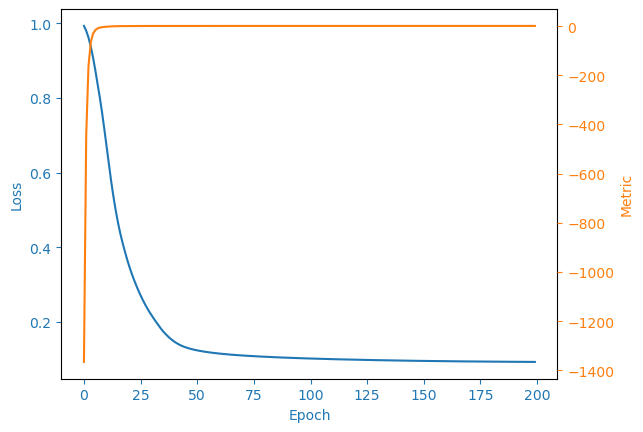

In [18]:
save_path = 'STORAGE/AI_MODEL_3D_DIM16.pth'
load = False
dim = int(RandDeviationVect.getDimension())
neural_model = otaf.surrogate.NeuralRegressorNetwork(
    dim, 1,
    Xtrain, ytrain, 
    clamping=True, 
    finish_critertion_epoch=15,
    loss_finish=1e-5, 
    metric_finish=0.999,
    r2_finish=0.95,
    max_epochs=200, 
    batch_size=7000, 
    compile_model=False, 
    train_size=0.45, 
    save_path = save_path,
    input_description=RandDeviationVect.getDescription(),
    display_progress_disable=False)

lr=0.002
#neural_model.model = otaf.surrogate.get_variable_size_sequential_linear_model(
    #dim, relative_max_layer_size=5, relative_max_layer_depth=0.5,  relative_layer_number=0.2)
#neural_model.model = otaf.surrogate.get_base_relu_mlp_model(dim, False)
neural_model.model = KAN([dim, int(dim*1.5), max(dim//3, 4), 1])
neural_model.optimizer = otaf.torch.optim.Adam(neural_model.parameters(), lr=lr) #AdamW(neural_model.parameters(), lr=lr, weight_decay=1e-3)   #
#otaf.surrogate.initialize_model_weights(neural_model.model)
neural_model.scheduler =  otaf.torch.optim.lr_scheduler.ExponentialLR(neural_model.optimizer, 1.0025)
neural_model.loss_fn = otaf.torch.nn.MSELoss()
#neural_model.loss_fn = otaf.surrogate.LimitSpaceFocusedLoss(0.001, 2, square=True)
#neural_model.loss_fn = otaf.surrogate.PositiveLimitSpaceFocusedLoss(0.0001, 1.73, 3, square=True)
if os.path.exists(save_path) and load:
    neural_model.load_model()
else :
    neural_model.train_model()
    neural_model.plot_results()
    neural_model.save_model()

In [19]:
neural_model.y.shape

torch.Size([80000, 1])

In [20]:
composed_dist0 = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
    RandDeviationVect, 
    lambda_sample_conditioned[31])
pf0 = neural_model.pf_monte_carlo_bruteforce(composed_dist0,
        N_MC_MAX=int(1e9),
        N_GEN_MAX=int(1e7),
        batch_size=500000,
        PF_STAB=1e-7,
        threshold=0.0,)
print(pf0)

Finished at iteration 2 with 10500000 experiments. Pf: 5.714285714285714e-07
5.714285714285714e-07


# Calculating probability of failure in the whole imprecise space

### Using the neural network surrogate model and bruteforce montecarlo.

In [21]:
# Let's first generate a classic LHS design of expezriment of size 16.
D_lambd = len(TAMP.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, TAMP.deviation_symbols)))
N_lambda = 200
lambda_sample_unconditioned = otaf.uncertainty.generateLHSExperiment(lambda_vect_unconditioned ,N_lambda, 999)
#lambda_sample_unconditioned = lambda_sample_unconditioned_generator.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = otaf.uncertainty.condition_lambda_sample(lambda_sample_random, squared_sum=True)
print(", ".join(map(str, TAMP.gap_symbols)))
print("\n")
print(", ".join(map(str, TAMP.deviation_symbols)))

u_g_0, v_g_0, w_g_0, alpha_g_0, beta_g_0, gamma_g_0, v_g_1, w_g_1, u_g_2, v_g_2, w_g_2, alpha_g_2, beta_g_2, gamma_g_2, s


v_d_0, w_d_0, beta_d_0, gamma_d_0, v_d_1, w_d_1, beta_d_1, gamma_d_1, v_d_4, w_d_4, beta_d_4, gamma_d_4, v_d_5, w_d_5, beta_d_5, gamma_d_5


#### Calculating over surrogate model

In [22]:
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = int(1e5) #1e4
failure_probabilities, s_values = [], []

start_time = time()  # Record the start time
for i in range(N_lambda):
    print(f"Doing iteration {i} of {N_lambda}")
    if i>0:
        print(f"Failure probability, Min: {min(failure_probabilities)}, / Max: {max(failure_probabilities)}")
    ot.RandomGenerator.SetSeed(SEED_MC_PF)
    composed_dist = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
        RandDeviationVect, 
        lambda_sample_conditioned[i])
    pf = neural_model.pf_monte_carlo_bruteforce(composed_dist,
            N_MC_MAX=int(1e9),
            N_GEN_MAX=int(1e7),
            batch_size=250000,
            PF_STAB=3*1e-7,
            threshold=0.0,)
    failure_probabilities.append(pf)
    clear_output(wait=True)
print(f"Done {len (lambda_sample_conditioned)} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

X = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

Done 200 experiments.
Elapsed time: 1141.154 seconds.


Lower probability of failure: 0.00000e+00
Upper probability of failure: 6.17143e-05


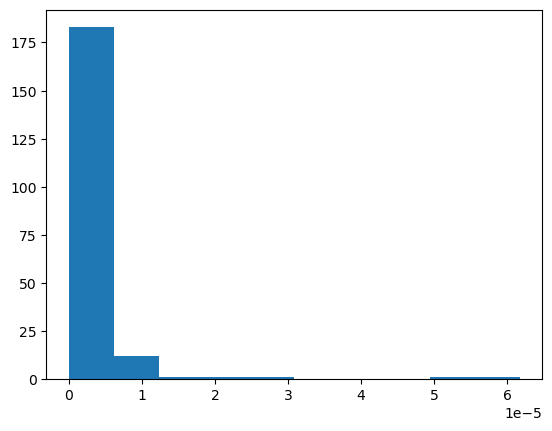

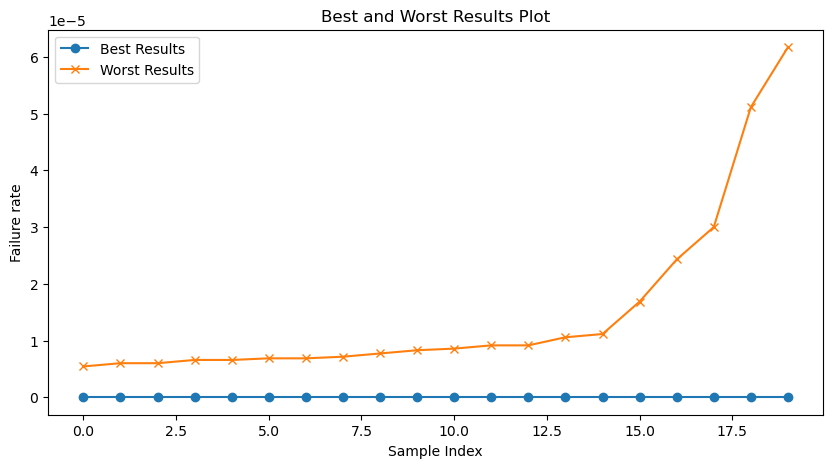

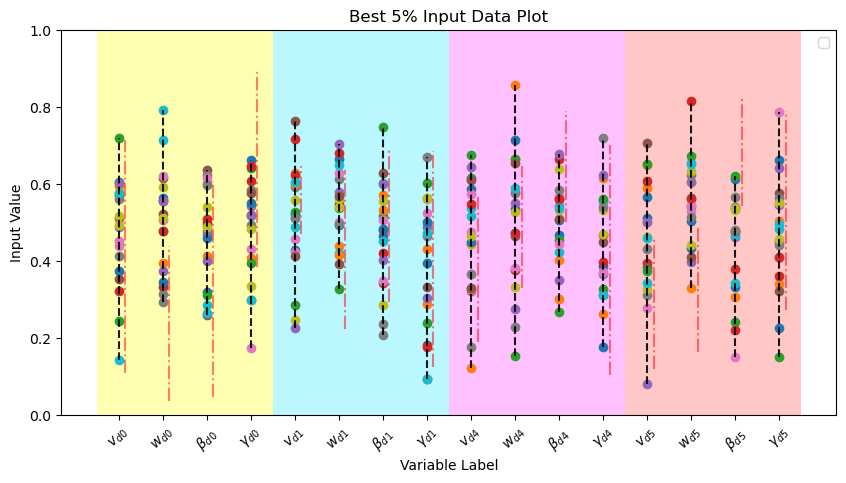

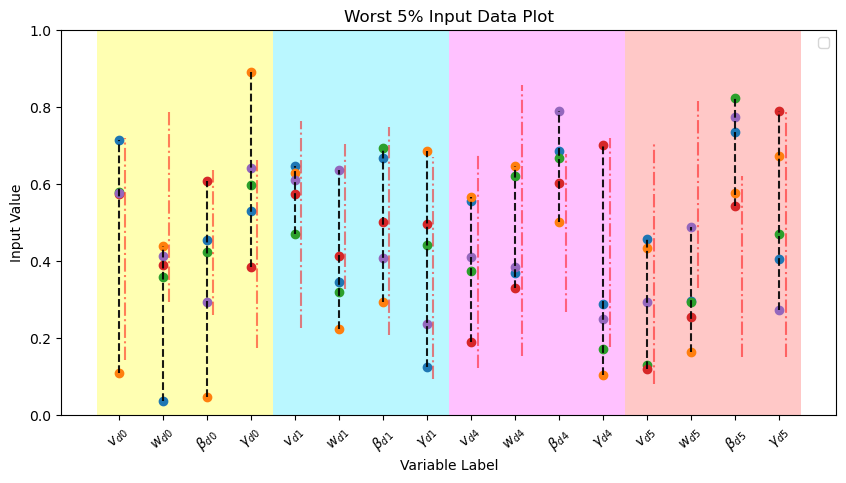

In [23]:
print("Lower probability of failure:", "{:.5e}".format(min(failure_probabilities)))
print("Upper probability of failure:", "{:.5e}".format(max(failure_probabilities)))
plt.hist(failure_probabilities)
plt.show()
otaf.plotting.plot_best_worst_results(best_5p_res, worst_5p_res, figsize=(10,5))

variable_labels = [var for var in lambda_sample_conditioned.getDescription()]
otaf.plotting.plot_best_worst_input_data(best_5p_lambda, worst_5p_lambda[-6:-1], variable_labels, figsize=(10,5), labels=False)

# Using the score function aproach on the neural surrogate.

In [24]:
N_SAMPLE_MINI = int(1e6)
standards = [RandDeviationVect.getParameter()[i] for i , param in enumerate(RandDeviationVect.getParameterDescription()) if ("standard" in param or 'sigma' in param)] 
means = [RandDeviationVect.getParameter()[i] for i , param in enumerate(RandDeviationVect.getParameterDescription()) if ("mean" in param or "mu" in param)] 
sample = np.array(RandDeviationVect.getSample(N_SAMPLE_MINI))
threshold = 0 
def model(x):
    return np.squeeze(neural_model.evaluate_model_non_standard_space(x).detach().numpy())

def optimization_function_mini(x, return_jac=True, output_upscale=1): 
    res = otaf.uncertainty.monte_carlo_non_compliancy_rate_w_gradient(
        threshold, sample, means, standards, model)(x)
    if not return_jac:
        return res[0]*output_upscale
    return res[0]*output_upscale, res[1]*output_upscale

def optimization_function_maxi(x, return_jac=True, output_upscale=1): 
    res = otaf.uncertainty.monte_carlo_non_compliancy_rate_w_gradient(
        threshold, sample, means, standards, model)(x)
    if not return_jac:
        return res[0]*output_upscale
    return -1*res[0]*output_upscale, -1*res[1]*output_upscale
otaf.torch.cuda.empty_cache()

In [25]:
lambda0 =  lambda_vect_unconditioned.getSample(1)
lambda0 = np.squeeze(otaf.uncertainty.condition_lambda_sample(lambda0, squared_sum=False))

In [26]:
cons, linearConstraint = otaf.uncertainty.lambda_constraint_dict_from_composed_distribution(
    RandDeviationVect, tol=1e-9)
bounds_lambda = otaf.uncertainty.bounds_from_composed_distribution(RandDeviationVect)

In [27]:
res = minimize(optimization_function_mini,lambda0,args=(True,1),
         jac=True, method="SLSQP", 
         options={"disp":True, "maxiter":100, "ftol":1e-9, "eps":1e-7},      
         bounds=bounds_lambda, constraints=cons)

print(res)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0
       x: [ 2.101e-01  1.761e-01 ...  2.817e-01  1.055e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 1
    njev: 1


res = minimize(optimization_function_mini, lambda0,args=(True,1000),
         jac=True, method="SLSQP", 
         options={"disp":True, "maxiter":100, "ftol":1e-9, "eps":1e-7},
         bounds=bounds_lambda, constraints=cons)

print(res)

## Trying other global optimization techniques.

 - differential_evolution
 - brute
 - 

### FORM

### Probability of failure in imprecise space with neural network + FORM

failure_probabilities = []

start_time = time()  # Record the start time
for i in range(N_lambda):
    print(f"Doing iteration {i} of {N_lambda}")
    if i>0:
        print(f"Failure probability, Min: {min(failure_probabilities)}, / Max: {max(failure_probabilities)}")
        print("s_mean: ", s_values.mean().round(3), "s_min: ", np.nanmin(s_values).round(3), "s_max: ", np.nanmax(s_values).round(3))
    composed_dist = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
        RandDeviationVect, 
        lambda_sample_conditioned[i])
    pf, result = otaf.uncertainty.compute_failure_probability_FORM(
        neural_model.get_model_as_openturns_function(), 
        composed_dist, 
        start_point = RandDeviationVect.getMean(),
        solver = ot.NLopt()) #ot.AbdoRackwitz() | ot.NLopt() | ot.Cobyla()
        
    failure_probabilities.append(pf)
    clear_output(wait=True)
print(f"Done {len (lambda_sample_conditioned)} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

X = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

print("Lower probability of failure:", "{:.5e}".format(min(failure_probabilities)))
print("Upper probability of failure:", "{:.5e}".format(max(failure_probabilities)))
plt.hist(failure_probabilities)
plt.show()
otaf.plotting.plot_best_worst_results(best_5p_res, worst_5p_res, figsize=(10,5))

variable_labels = [var for var in lambda_sample_conditioned.getDescription()]
otaf.plotting.plot_best_worst_input_data(best_5p_lambda, worst_5p_lambda, variable_labels, figsize=(10,5), labels=False)

In [28]:
ot.ResourceMap.Set('SimulationAlgorithm-DefaultBlockSize', '4')
ot.ResourceMap.Set('SimulationAlgorithm-DefaultMaximumCoefficientOfVariation', '0.1')
ot.ResourceMap.Set('SimulationAlgorithm-DefaultMaximumOuterSampling', '50000')
ot.ResourceMap.Set('SimulationAlgorithm-DefaultMaximumStandardDeviation', '0.005')
ot.ResourceMap.Set('SubsetSampling-DefaultConditionalProbability', '0.3')
ot.ResourceMap.Set('SubsetSampling-DefaultBetaMin', '3')
ot.ResourceMap.Set('SubsetSampling-DefaultMaximumOuterSampling', '50000')
ot.ResourceMap.Set('SubsetSampling-DefaultProposalRange', '1')

In [ ]:
tstart = time()
composed_dist0 = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
    RandDeviationVect, 
    lambda_sample_conditioned[0])
pf, result, algo = otaf.uncertainty.compute_failure_probability_SUBSET(
    neural_model.get_model_as_openturns_function(batch_size=250000), 
    composed_dist0, verbose=True,
    proposalRange=3, targetProbability=0.1)
print("Took {:.3f}s with {} steps.".format(time()-tstart, algo.getStepsNumber()))

In [ ]:
tstart = time()
composed_dist0 = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
    RandDeviationVect, 
    lambda_sample_conditioned[0])
pf, result = otaf.uncertainty.compute_failure_probability_NAIS(
    neural_model.get_model_as_openturns_function(), 
    composed_dist0, verbose=True)
print("Took {:.3f}s".format(time()-tstart))

## Importance sampling

### Probability of failure in imprecise space with neural network + importance sampling

In [ ]:
failure_probabilities = []

start_time = time()  # Record the start time
for i in range(N_lambda):
    print(f"Doing iteration {i} of {N_lambda}")
    if i>0:
        print(f"Failure probability, Min: {min(failure_probabilities):.6f}, / Max: {max(failure_probabilities):.6f}")
    composed_dist = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
        RandDeviationVect, 
        lambda_sample_conditioned[i])
    pf, result = otaf.uncertainty.compute_failure_probability_NAIS(
        neural_model.get_model_as_openturns_function(), 
        composed_dist,
        quantile_level=0.25,
        verbose=True)
        
    failure_probabilities.append(pf)
    clear_output(wait=True)
print(f"Done {len (lambda_sample_conditioned)} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

X = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

In [ ]:
print("Lower probability of failure:", "{:.5e}".format(min(failure_probabilities)))
print("Upper probability of failure:", "{:.5e}".format(max(failure_probabilities)))
plt.xscale('log')
plt.hist(failure_probabilities)
plt.show()
otaf.plotting.plot_best_worst_results(best_5p_res, worst_5p_res, figsize=(10,5))

variable_labels = [var for var in lambda_sample_conditioned.getDescription()]
otaf.plotting.plot_best_worst_input_data(best_5p_lambda, worst_5p_lambda[-3:], variable_labels, figsize=(10,5), labels=False)

In [ ]:
import UQpy
def get_uqpy_distribution_list_from_ot_composed_distirbution(composed_distribution):
    # Assumes all distributions are normals.
    uqpy_dist_list = []
    for distribution in composed_distribution.getDistributionCollection():
        if distribution.getName() == 'Normal':
            mu = distribution.getMean()[0]
            sigma = distribution.getStandardDeviation()[0]
            uqdist = UQpy.Normal(mu, sigma)
            uqpy_dist_list.append(uqdist)
        else :
            raise ValueError('Error in composed distribution, not Normal')
    return uqpy_dist_list

def get_metropolis_hastings_from_UQ_distribution_list(uqpy_dist_list, n_chains=1000):
    joint_dist = UQpy.distributions.collection.JointIndependent(uqpy_dist_list)
    mh_algo = UQpy.sampling.mcmc.MetropolisHastings(log_pdf_target = joint_dist.log_pdf, dimension=len(uqpy_dist_list), n_chains=n_chains)
    return mh_algo


In [ ]:
from UQpy import PythonModel
from UQpy.reliability import SubsetSimulation
from UQpy.run_model import RunModel

def compute_failure_probability_UQPy(
    python_function, composed_distribution, conditional_probability=0.1, nsamples_per_subset=int(1e5),
    verbose=False, nsamples=1e4, random_state=352163854
):
    uqpy_dist_list = get_uqpy_distribution_list_from_ot_composed_distirbution(composed_distribution)
    sampling = get_metropolis_hastings_from_UQ_distribution_list(uqpy_dist_list)
    model = RunModel(model=python_function)
    sampling.run(int(nsamples))
    samples_init = sampling.samples
    # Set up the Subset Simulation
    ss = SubsetSimulation(
        sampling=sampling,  # No sampling needed, using pre-generated samples
        runmodel_object=model,
        conditional_probability=conditional_probability,
        nsamples_per_subset=nsamples_per_subset,
        samples_init=samples_init
    )

    # Execute the Subset Simulation
    ss.run()

    # Verbose output if required
    if verbose:
        print("Estimated Failure Probability: ", ss.failure_probability)

    return ss.failure_probability

In [ ]:
composed_dist = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(
    RandDeviationVect, 
    lambda_sample_conditioned[0])

In [ ]:
def min_f_nais(lambda_array):
    composed_distribution = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(composed_dist, lambda_array)
    pf, result = otaf.uncertainty.compute_failure_probability_NAIS(
            neural_model.get_model_as_openturns_function(), 
            composed_dist,
            quantile_level=0.25,
            verbose=True)
    return pf

def max_f_nais(lambda_array):
    composed_distribution = otaf.uncertainty.multiply_composed_distribution_standard_with_constants(composed_dist, lambda_array)
    pf, result = otaf.uncertainty.compute_failure_probability_NAIS(
            neural_model.get_model_as_openturns_function(), 
            composed_dist,
            quantile_level=0.25,
            verbose=True)
    return -1*pf

In [ ]:
res = minimize(min_f_nais,lambda0,
         jac=False, method="SLSQP", 
         options={"disp":True, "maxiter":50, "ftol":1e-14, "eps":1e-6},      
         bounds=bounds_lambda, constraints=cons)

print(res)

In [ ]:
res = minimize(max_f_nais,lambda0,
         jac=False, method="SLSQP", 
         options={"disp":True, "maxiter":50, "ftol":1e-14, "eps":1e-6},      
         bounds=bounds_lambda, constraints=cons)

print(res)